In [ ]:
#Importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [ ]:
# fetch dataset
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544)

# data (as pandas dataframes)
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets

df = pd.concat([X, y], axis=1)

In [ ]:
# Check for missing values
print("Missing value from categories:")
print(df.isnull().sum())

Missing value from categories:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [ ]:
# Data Cleaning and Preprocessing
df.rename(columns = {'family_history_with_overweight': 'Family_History',
                   'FAVC': 'Frequent_Consumption_of_High_Caloric_Foods',
                   'SMOKE': 'Smoking',
                   'CH2O': 'Daily_Water_Intake',
                   'SCC': 'Calories_Consumption_Monitoring',
                   'FAF': 'Physical_Activity_Frequency',
                   'TUE': 'Time_Using_Technology_Devices',
                   'CALC': 'Consumption_of_Alcohol',
                   'MTRANS': 'Transportation_Type',
                   'NObeyesdad': 'Obesity_Level'}, inplace = True)

df['Gender'] = df['Gender'].replace({'Male': 'Male', 'Female': 'Female'})

In [ ]:
# Convert Height and Weight to numeric, handling errors
df['Height'] = pd.to_numeric(df['Height'], errors = 'coerce')
df['Weight'] = pd.to_numeric(df['Weight'], errors = 'coerce')

In [ ]:
# Drop rows where Height or Weight are NaN after conversion
df.dropna(subset = ['Height', 'Weight'], inplace = True)

In [ ]:
#BMI Calculation
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

In [ ]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include = ['object']).columns
numerical_features = X.select_dtypes(include = ['int64', 'float64']).columns

In [ ]:
# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_features)
    ])

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
# Create a pipeline with a classification model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', RandomForestClassifier(random_state = 42))])

In [ ]:
# Convert y_train to numerical representation using LabelEncoder
le = LabelEncoder()

# Train the model
y_train_encoded = le.fit_transform(y_train)
pipeline.fit(X_train, y_train_encoded)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object'))])),
                ('model', RandomForestClassifier(random_state=42))])

In [ ]:
# Make predictions
y_pred_encoded = pipeline.predict(X_test)

# Instead of inverting, I had to convert y_test to encoded format for comparison
# Encode y_test to avoid warnings
y_test_encoded = le.transform(y_test.values.ravel())

# Evaluate the model using a classification metric, such as accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9261363636363636


In [ ]:
# Implement cross-validation for a more robust evaluation using a classification metric
# Convert y to numerical representation before cross-validation
y_encoded = le.fit_transform(y.values.ravel())  # Encode y before cross-validation, ravel to avoid warnings
cv_scores = cross_val_score(pipeline, X, y_encoded, cv=5, scoring = 'accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores)}")

Cross-Validation Accuracy Scores: [0.69976359 0.97630332 0.98104265 0.98104265 0.98104265]
Mean Cross-Validation Accuracy: 0.9238389746002935


In [ ]:
#Average BMI, Age, and Weight by Gender
gender_group = df.groupby('Gender')
avg_bmi_gender = gender_group['BMI'].mean()
avg_age_gender = gender_group['Age'].mean()
avg_weight_gender = gender_group['Weight'].mean()

print("\nAverage BMI by Gender:")
print(avg_bmi_gender)
print("\nAverage Age by Gender:")
print(avg_age_gender)
print("\nAverage Weight by Gender:")
print(avg_weight_gender)


Average BMI by Gender:
Gender
Female    30.130002
Male      29.280377
Name: BMI, dtype: float64

Average Age by Gender:
Gender
Female    24.001907
Male      24.616020
Name: Age, dtype: float64

Average Weight by Gender:
Gender
Female    82.302364
Male      90.769478
Name: Weight, dtype: float64


In [ ]:
#Family History of Obesity by Gender
family_history_counts = df.groupby('Gender')['Family_History'].value_counts()
print("\nFamily History of Obesity by Gender:")
print(family_history_counts)


Family History of Obesity by Gender:
Gender  Family_History
Female  yes               811
        no                232
Male    yes               915
        no                153
Name: count, dtype: int64


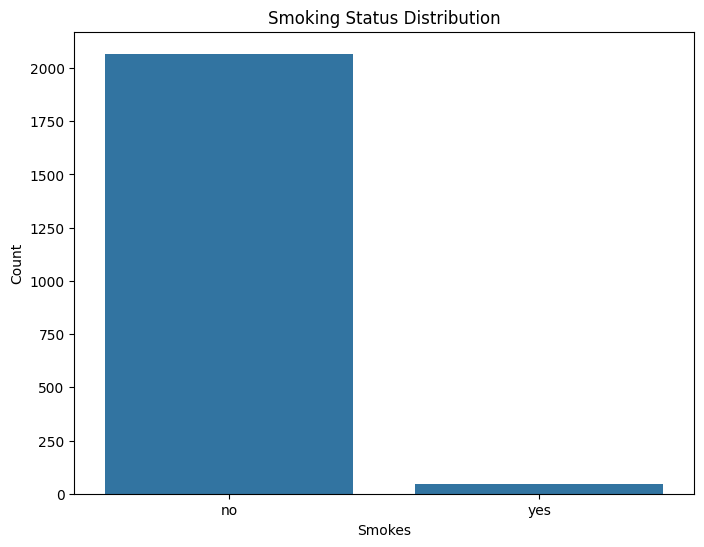

In [ ]:
#Visualization of Smoking Status
plt.figure(figsize = (8, 6))
sns.countplot(x = 'Smoking', data=df)
plt.title('Smoking Status Distribution')
plt.xlabel('Smokes')
plt.ylabel('Count')
plt.show()

In [ ]:
#Transportation Type Counts
transportation_counts = df['Transportation_Type'].value_counts()
print("\nTransportation Type Counts:")
print(transportation_counts)


Transportation Type Counts:
Transportation_Type
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64


In [ ]:
#Obesity Level Counts
obesity_level_counts = df['Obesity_Level'].value_counts()
print("\nObesity Level Counts:")
print(obesity_level_counts)


Obesity Level Counts:
Obesity_Level
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


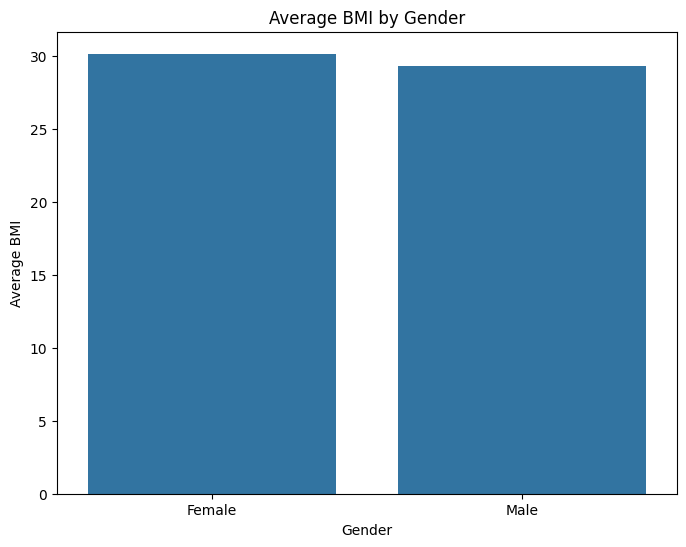

In [ ]:
#Visualization of Average BMI by Gender (Bar Chart)
plt.figure(figsize = (8, 6))
sns.barplot(x = avg_bmi_gender.index, y = avg_bmi_gender.values)
plt.title('Average BMI by Gender')
plt.xlabel('Gender')
plt.ylabel('Average BMI')
plt.show()

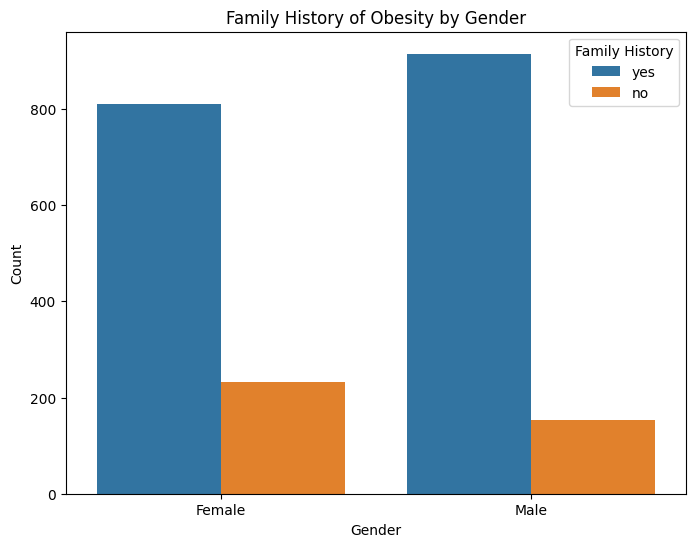

In [ ]:
#Visualization of Family History of Obesity by Gender
plt.figure(figsize = (8, 6))
sns.countplot(x = 'Gender', hue = 'Family_History', data = df)
plt.title('Family History of Obesity by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Family History')
plt.show()

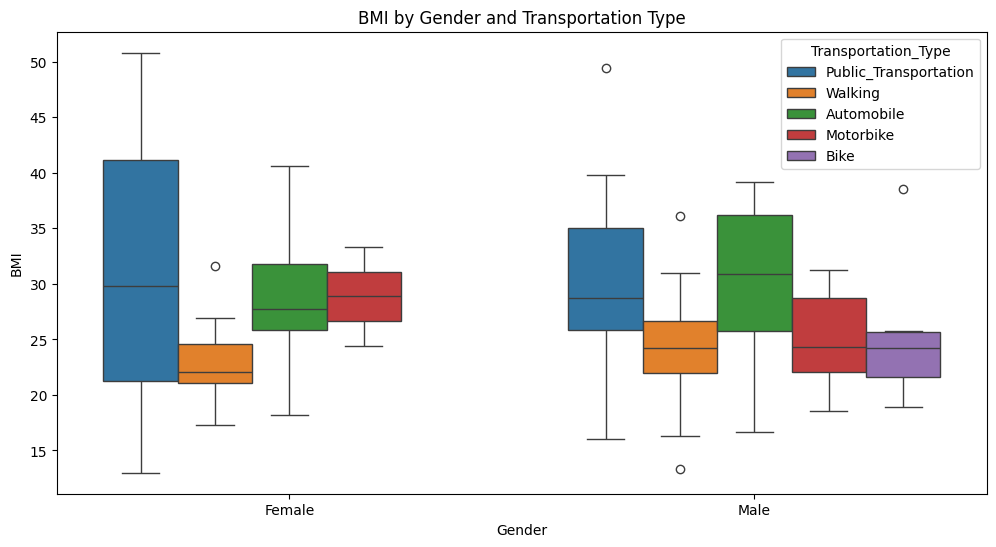

In [ ]:
#Visualization Comparing BMI by Gender and Transportation Type (Boxplot)
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Gender', y = 'BMI', hue = 'Transportation_Type', data = df)
plt.title('BMI by Gender and Transportation Type')
plt.xlabel('Gender')
plt.ylabel('BMI')
plt.show()

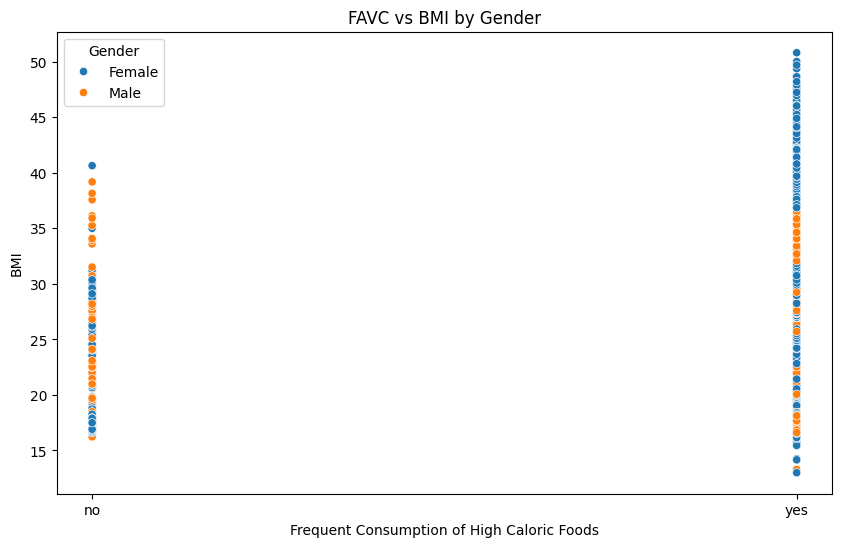

In [ ]:
#Visualization of FAVC vs BMI by Gender
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'Frequent_Consumption_of_High_Caloric_Foods', y = 'BMI', hue = 'Gender', data = df)
plt.title('FAVC vs BMI by Gender')
plt.xlabel('Frequent Consumption of High Caloric Foods')
plt.ylabel('BMI')
plt.show()

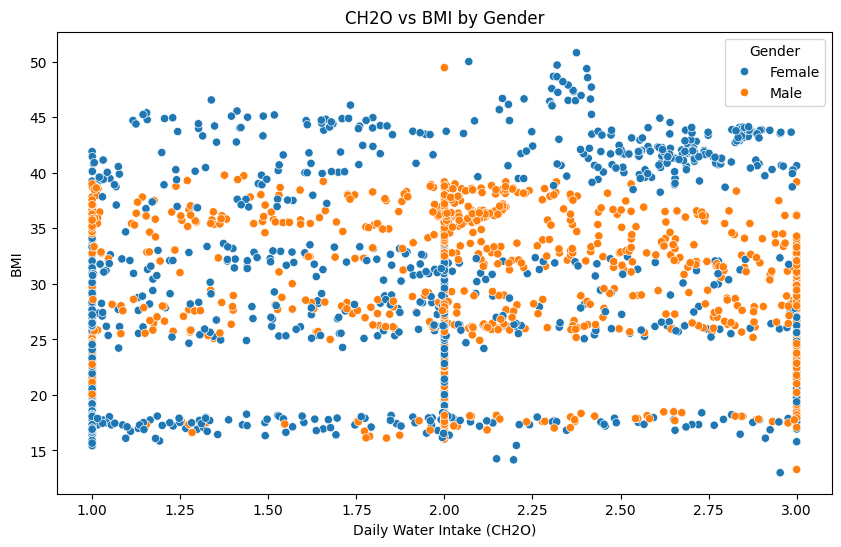

In [ ]:
#Visualization of CH2O vs BMI by Gender (Scatter Plot)
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'Daily_Water_Intake', y = 'BMI', hue = 'Gender', data = df)
plt.title('CH2O vs BMI by Gender')
plt.xlabel('Daily Water Intake (CH2O)')
plt.ylabel('BMI')
plt.show()

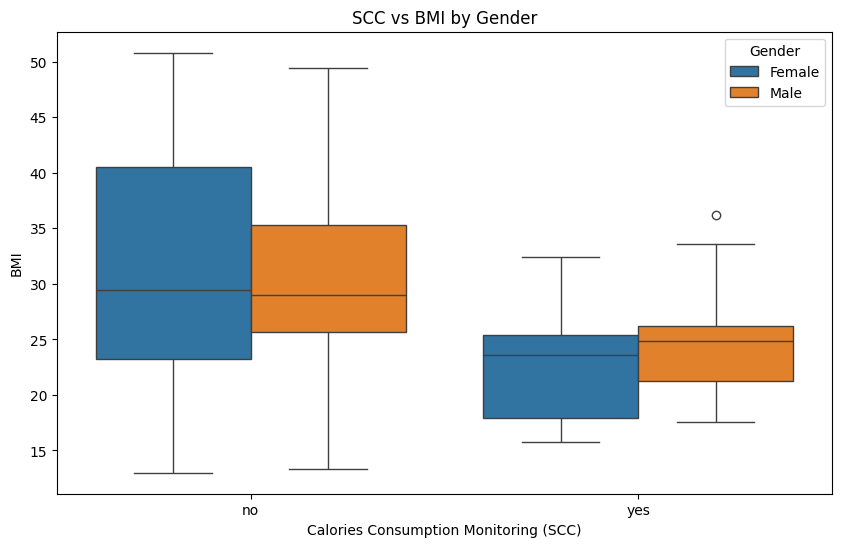

In [ ]:
#Visualization of SCC vs BMI by Gender (Boxplot)
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Calories_Consumption_Monitoring', y = 'BMI', hue = 'Gender', data = df)
plt.title('SCC vs BMI by Gender')
plt.xlabel('Calories Consumption Monitoring (SCC)')
plt.ylabel('BMI')
plt.show()

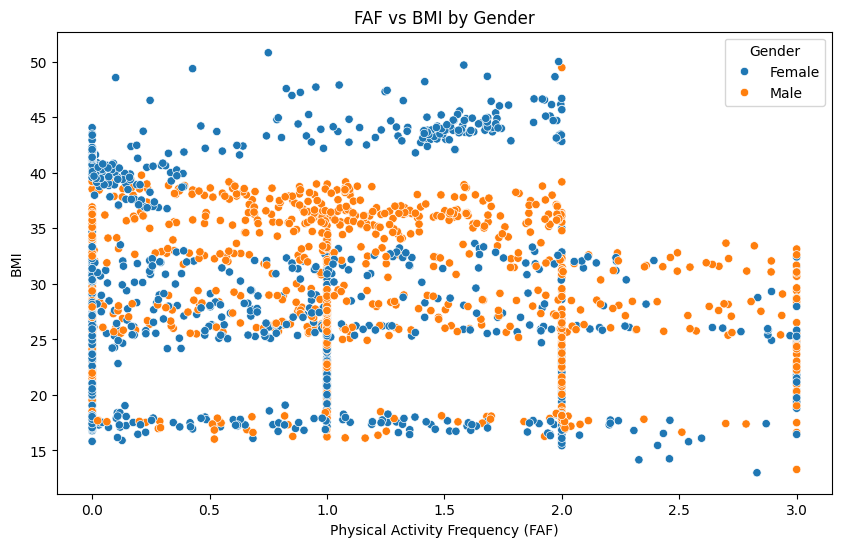

In [ ]:
#Visualization of FAF vs BMI by Gender
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'Physical_Activity_Frequency', y = 'BMI', hue = 'Gender', data = df)
plt.title('FAF vs BMI by Gender')
plt.xlabel('Physical Activity Frequency (FAF)')
plt.ylabel('BMI')
plt.show()

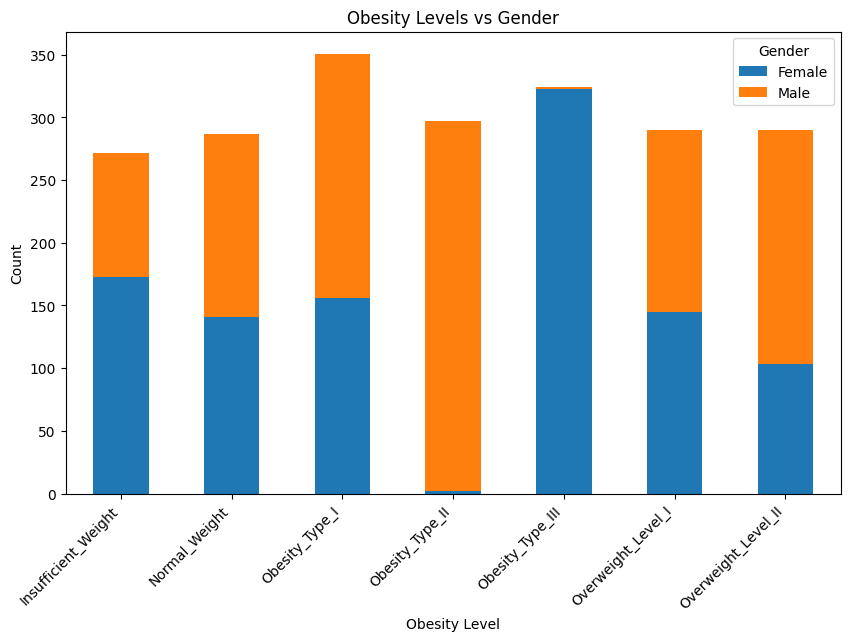

In [ ]:
#Visualization of Obesity Levels vs Gender
obesity_gender_table = pd.crosstab(df['Obesity_Level'], df['Gender'])
obesity_gender_table.plot(kind = 'bar', stacked=True, figsize = (10, 6))
plt.title('Obesity Levels vs Gender')
plt.xlabel('Obesity Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Define obesity level categories based on BMI (World Health Organization)
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 35:
        return 'Obese Class I'
    elif 35 <= bmi < 40:
        return 'Obese Class II'
    else:
        return 'Obese Class III'

df['Obesity_Category_Calculated'] = df['BMI'].apply(categorize_bmi)


In [ ]:
def get_tips(bmi_category):
    """
    Provides lifestyle tips based on BMI category.

    Args:
        bmi_category (str): BMI category.

    Returns:
        str: Tips for the given BMI category.
    """
    tips = {
        "Underweight": """
            - Focus on nutrient-dense foods: Choose whole grains, lean proteins,
              healthy fats, fruits, and vegetables.
            - Increase calorie intake gradually: Aim for small, frequent meals
              instead of large ones.
            - Include strength training: Build muscle mass to gain weight
              healthily.
            - Consult a healthcare professional:  A doctor or registered dietitian
              can provide personalized advice.
            - Consider adding healthy snacks:  Nuts, seeds, avocados, and full-fat
              dairy can help increase calorie intake.
            - Monitor your progress: Track your weight and adjust your plan as needed.
            """,
        "Normal weight": """
            - Maintain a balanced diet: Continue eating a variety of fruits,
              vegetables, whole grains, and lean proteins.
            - Stay physically active: Aim for at least 150 minutes of moderate-
              intensity or 75 minutes of vigorous-intensity aerobic activity
              per week.
            - Get enough sleep:  Prioritize 7-9 hours of quality sleep per night.
            - Manage stress: Practice stress-reduction techniques like yoga,
              meditation, or deep breathing.
            - Stay hydrated: Drink plenty of water throughout the day.
            - Schedule regular checkups:  See your doctor for routine health
              screenings.
            """,
        "Overweight": """
            - Focus on calorie control:  Reduce your intake of processed foods,
              sugary drinks, and unhealthy fats.
            - Increase physical activity: Aim for at least 150 minutes of
              moderate-intensity aerobic activity per week.
            - Choose whole foods:  Emphasize fruits, vegetables, whole grains,
              and lean proteins.
            - Limit portion sizes:  Be mindful of how much you're eating at each
              meal.
            - Stay hydrated: Drink plenty of water.
            - Consider a support system:  Join a weight loss group or work with
              a registered dietitian.
            """,
        "Obese Class I": """
            - Implement significant lifestyle changes: Focus on a long-term
              commitment to healthy eating and regular exercise.
            - Seek professional guidance: Consult a doctor, registered dietitian,
              or certified personal trainer.
            - Consider a structured weight loss program:  These programs can
              provide support and accountability.
            - Monitor your health:  Regularly check for obesity-related
              conditions like diabetes, heart disease, and sleep apnea.
             - Set realistic goals: Aim for gradual and sustainable weight loss.
            - Explore different types of exercise: Find activities you enjoy,
              such as swimming, walking, or cycling.
            """,
        "Obese Class II": """
            - Adopt a comprehensive approach: Combine intensive lifestyle
              modifications with medical supervision.
            - Work with a multidisciplinary team:  Include a physician,
              dietitian, psychologist, and exercise specialist.
            - Consider medical interventions:  Discuss options like weight loss
              medications or bariatric surgery with your doctor.
            - Address underlying issues:  Explore any emotional or psychological
              factors that may be contributing to obesity.
            - Focus on long-term management:  Obesity is a chronic condition that
              requires ongoing care.
            -  Get support:  Join a support group to connect with others facing
               similar challenges.
            """,
        "Obese Class III": """
            - Prioritize immediate medical attention:  Severe obesity carries
              a high risk of serious health problems.
            - Explore all treatment options:  This may include intensive lifestyle
              changes, medication, and bariatric surgery.
            - Seek a specialized obesity clinic:  These clinics have the
              resources and expertise to manage complex cases.
            -  Prepare for significant lifestyle changes: These need to be
               long term and possibly life long.
            -  Focus on improving overall health:  Address any co-existing
               conditions, such as diabetes or heart disease.
            -  Have a strong support system:  Lean on family, friends, and
               professionals for encouragement and assistance.
            """,
        "Invalid BMI": "Invalid input. Please check your weight and height."
    }
    return tips.get(bmi_category, "No tips available for this category.")


In [ ]:
# Prepare data for the machine learning model focused on BMI categories
#I did this because if not it would make me enter all of the questionnaire questions
X_ml = df[['Gender', 'Height', 'Weight']]
y_ml = df['Obesity_Category_Calculated']


In [ ]:
# Identify categorical and numerical features for the model
categorical_features_ml = ['Gender']
numerical_features_ml = ['Height', 'Weight']

In [ ]:
# Create a preprocessor for the machine learning model
preprocessor_ml = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_ml),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ml)
    ])

In [ ]:
# I'm retraining the data because when I tried to just use the old training
# model I kept getting errors about the categories Split data into training and
# testing sets
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size = 0.2, random_state = 42)

In [ ]:
# Create a pipeline with a classification model (Logistic Regression as a simple starting point)
pipeline_ml = Pipeline(steps = [('preprocessor', preprocessor_ml),
                               ('classifier', LogisticRegression(random_state = 42))])

In [ ]:
# Train the model
pipeline_ml.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Height', 'Weight']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [ ]:
# Get user input
print("Please enter your details to determine your BMI category:")
gender_user = input("Gender (Male/Female): ").capitalize()
try:
    height_user = float(input("Height (in meters): "))
    weight_user = float(input("Weight (in kilograms): "))
except ValueError:
    print("Invalid input for height or weight. Please enter numeric values.")
    exit()

Please enter your details to determine your BMI category:
Gender (Male/Female): Male
Height (in meters): 1.63
Weight (in kilograms): 104


In [ ]:
# Create a DataFrame for the user input
user_data = pd.DataFrame({'Gender': [gender_user], 'Height': [height_user], 'Weight': [weight_user]})

In [ ]:
# Predict the BMI category for the user
predicted_category_user = pipeline_ml.predict(user_data)[0]
print(f"\nBased on your input, your BMI category is predicted to be: {predicted_category_user}")


Based on your input, your BMI category is predicted to be: Obese Class II


In [ ]:
# Calculate user's BMI for visualization
bmi_user = weight_user / (height_user ** 2)

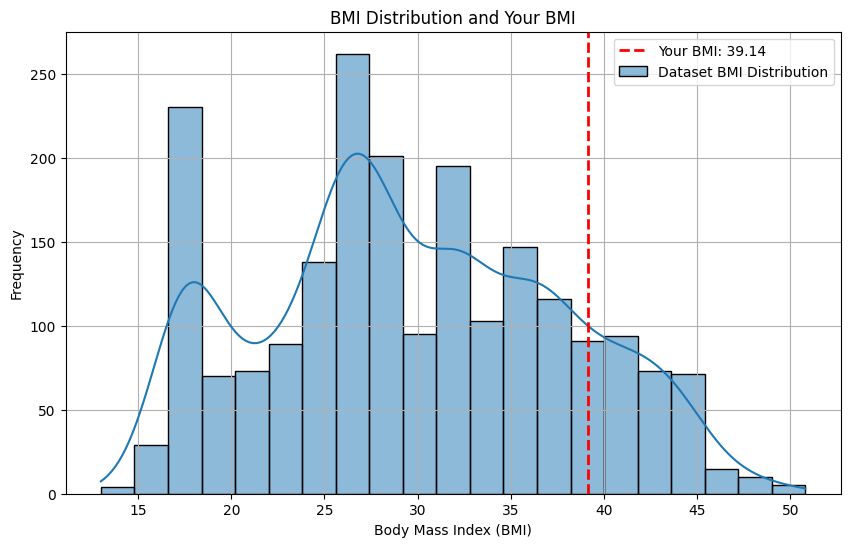

In [ ]:
# Visualization: Compare user's BMI to the distribution of BMIs in the dataset
plt.figure(figsize = (10, 6))
sns.histplot(df['BMI'], kde=True, label = 'Dataset BMI Distribution')
plt.axvline(bmi_user, color = 'red', linestyle = 'dashed', linewidth = 2, label = f'Your BMI: {bmi_user:.2f}')
plt.title('BMI Distribution and Your BMI')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

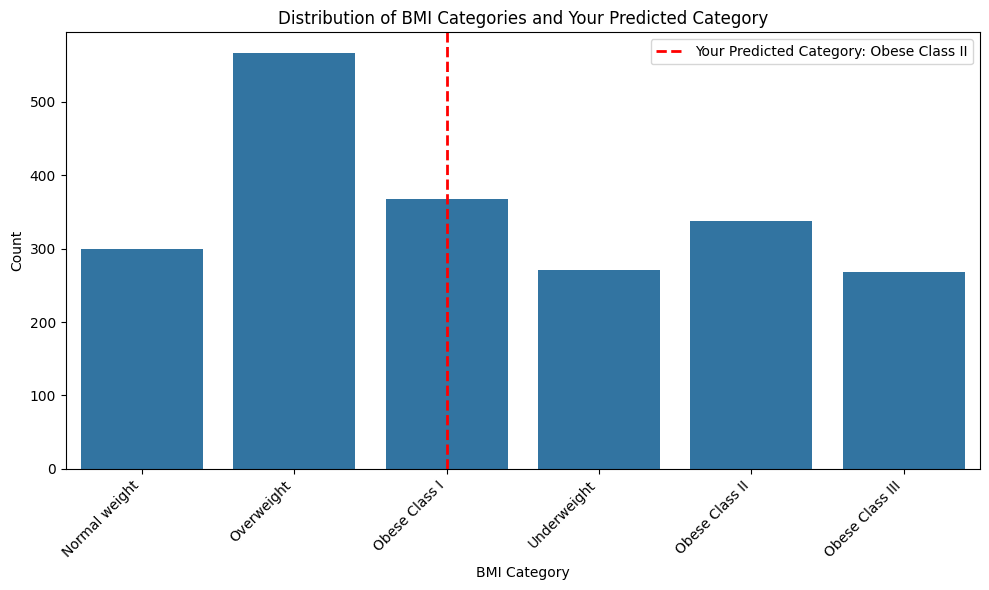

In [ ]:
# Visualization: Compare user's BMI category to the distribution of BMI categories in the dataset
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'Obesity_Category_Calculated')
plt.axvline(x = df['Obesity_Category_Calculated'].value_counts().index.get_loc(predicted_category_user), color = 'red', linestyle = 'dashed', linewidth = 2, label = f'Your Predicted Category: {predicted_category_user}')
plt.title('Distribution of BMI Categories and Your Predicted Category')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.xticks(rotation = 45, ha = 'right')
plt.legend()
plt.tight_layout()
plt.show()

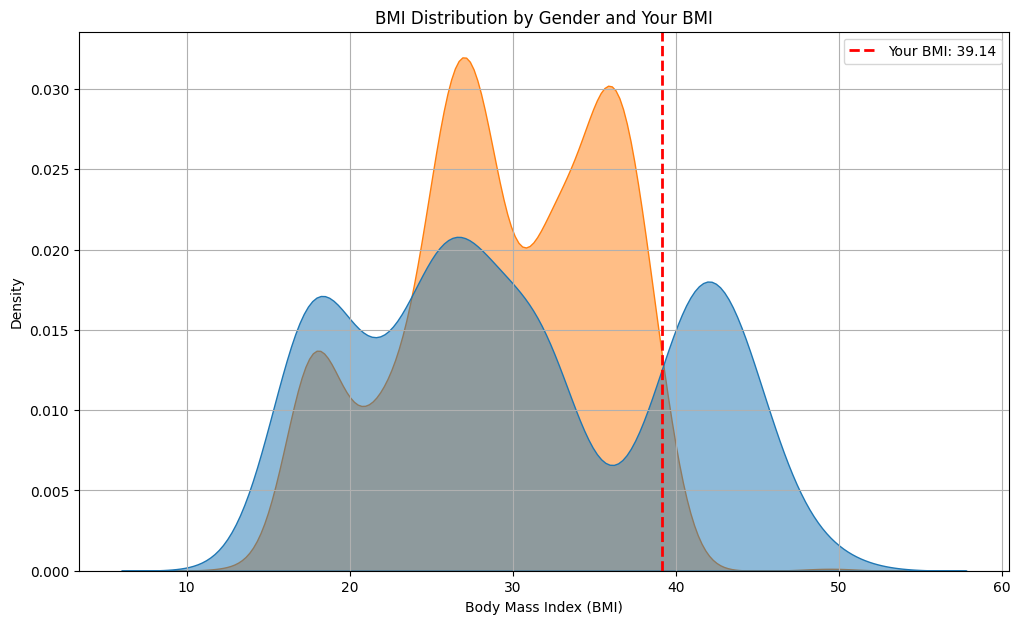

In [ ]:
# Visualization: BMI distribution by Gender with user's BMI highlighted
plt.figure(figsize = (12, 7))
sns.kdeplot(data = df, x = 'BMI', hue = 'Gender', fill = True, alpha = 0.5)
plt.axvline(bmi_user, color = 'red', linestyle = '--', linewidth=2, label = f'Your BMI: {bmi_user:.2f}')
plt.title('BMI Distribution by Gender and Your BMI')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
tips = get_tips(predicted_category_user)
print(f"Tips for BMI: {predicted_category_user} ")
print(tips)

Tips for BMI: Obese Class II 

            - Adopt a comprehensive approach: Combine intensive lifestyle
              modifications with medical supervision.
            - Work with a multidisciplinary team:  Include a physician,
              dietitian, psychologist, and exercise specialist.
            - Consider medical interventions:  Discuss options like weight loss
              medications or bariatric surgery with your doctor.
            - Address underlying issues:  Explore any emotional or psychological
              factors that may be contributing to obesity.
            - Focus on long-term management:  Obesity is a chronic condition that
              requires ongoing care.
            -  Get support:  Join a support group to connect with others facing
               similar challenges.
            
